In [1]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.io import wavfile
import librosa
import IPython
import IPython.display as ipd 

from keras.layers import Dense, Dropout, Input, ReLU
from keras.models import Model, Sequential
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras import models

In [2]:
# Audio Config
DURATION = 4
SAMPLE_RATE = 16000
AUDIO_SHAPE = SAMPLE_RATE*DURATION

MFCC = 40

# Paths
DATASET_PATH = "./data/"

# Load 
def load_train_data(label, input_length=AUDIO_SHAPE):
    train = pd.read_csv(DATASET_PATH + "train.csv")
    if label != None:
        train_list = train.loc[train.label == label]
    else: 
        train_list = train
    cur_batch_size = len(train_list)
    train_fname_list = train_list.fname
    X = np.empty((cur_batch_size, input_length))
    for i, train_fname in enumerate(train_fname_list):
        file_path = DATASET_PATH + "audio_train/" + train_fname
        
        # Read and Resample the audio
        data, _ = librosa.core.load(file_path, sr=SAMPLE_RATE, res_type='kaiser_fast')

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
        X[i,] = data
    print("Data Loaded...")
    return X

# Stardize Data 
def normalization(X):
    mean = X.mean(keepdims=True)
    std = X.std(keepdims=True)
    X = (X - mean) / std
    print("Data Normalized...")
    return X

# Rescale Data to be in range [rangeMin, rangeMax]
def rescale(X, rangeMin=-1, rangeMax=+1):
    maxi = X.max()
    mini = X.min()
    X = np.interp(X, (mini, maxi), (rangeMin, rangeMax))
    print("Data Rescaled...")
    return X

In [3]:
train_data = normalization(load_train_data("Saxophone", AUDIO_SHAPE))

Data Loaded...
Data Normalized...


In [4]:
x_train = rescale(train_data)

Data Rescaled...


In [5]:
audio_samples = [x_train[0], x_train[2], x_train[10], x_train[20], x_train[42], x_train[100]] 

for audio in audio_samples:
        IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))

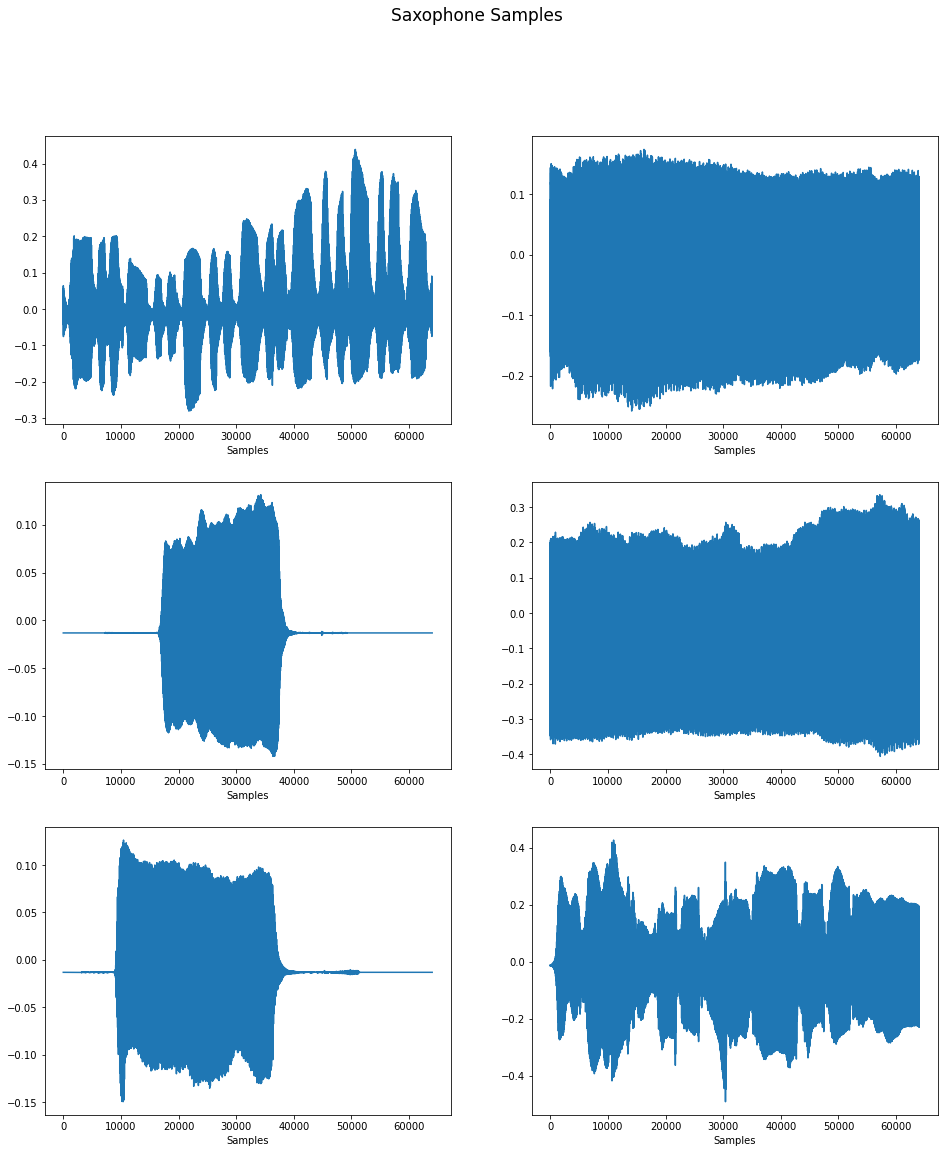

In [6]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*3)) 
    
# drwing plots
count = 0
for r in range(0,int(length_of_audio_samples/2)):
    for c in range(0,2):
        sample = audio_samples[count]
        ax[r,c].plot(sample)
        count += 1
        ax[r,c].set_xlabel("Samples")
        
fig.suptitle("Saxophone Samples", fontsize = 17)
plt.show()

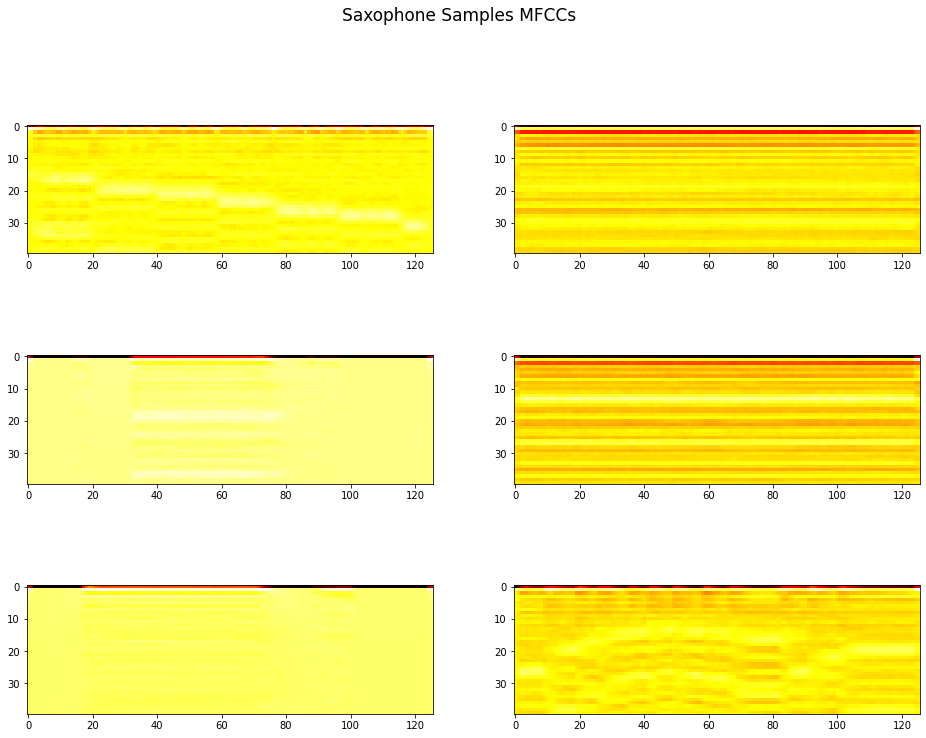

In [9]:
length_of_audio_samples = len(audio_samples)
fig, ax = plt.subplots(int(length_of_audio_samples/2),2, figsize = (16,length_of_audio_samples*2)) 
    
# drowing plots
count = 0
for r in range(0, int(length_of_audio_samples/2)):
    for c in range(0, 2):
        sample = audio_samples[count]
        mfcc = librosa.feature.mfcc(y=sample, sr=SAMPLE_RATE, n_mfcc=40)
        ax[r, c].imshow(mfcc, cmap='hot', interpolation='nearest')
        count += 1
        
fig.suptitle("Saxophone Samples MFCCs", fontsize = 17)
plt.show()


In [10]:
def create_generator():
    
    generator = Sequential()
    generator.add(Dense(units = 512, input_dim = 100))
    generator.add(ReLU())
    
    generator.add(Dense(units = 512))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 1024))
    generator.add(ReLU())
    
    generator.add(Dense(units = 64000))
    
    generator.compile(loss ="binary_crossentropy",
                     optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    
    return generator

g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               51712     
                                                                 
 re_lu (ReLU)                (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 re_lu_1 (ReLU)              (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 re_lu_2 (ReLU)              (None, 1024)              0         
                                                                 
 dense_3 (Dense)             (None, 1024)              1

/home/user/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [11]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Dense(units = 1024,input_dim = 64000)) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 512)) 
    discriminator.add(ReLU())
    discriminator.add(Dropout(0.4))
    
    discriminator.add(Dense(units = 256)) 
    discriminator.add(ReLU())
    
    discriminator.add(Dense(units = 1, activation = "sigmoid"))
    
    discriminator.compile(loss = "binary_crossentropy",
                         optimizer = Adam(lr = 0.0001, beta_1 = 0.5))
    return discriminator

d = create_discriminator()
d.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 1024)              65537024  
                                                                 
 re_lu_4 (ReLU)              (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 re_lu_5 (ReLU)              (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 256)              

In [12]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = "binary_crossentropy", optimizer = "adam")
    return gan

gan = create_gan(d,g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 64000)             67489280  
                                                                 
 sequential_1 (Sequential)   (None, 1)                 66193409  
                                                                 
Total params: 133,682,689
Trainable params: 67,489,280
Non-trainable params: 66,193,409
_________________________________________________________________


In [13]:
def show_gen_samples(epochs, samples = 3):
    samplePlot = []
    fig        = plt.figure(figsize = (1, samples))
    noise      = np.random.normal(0, 1, (samples,100))
    audios     = g.predict(noise)        
    for i, audio in enumerate(audios):
        IPython.display.display(ipd.Audio(data = audio, rate = SAMPLE_RATE))
        samplePlot.append(fig.add_subplot(1, samples, i+1))
        samplePlot[i].plot(audio.flatten(), '-', )
    plt.gcf().set_size_inches(25, 5)
    plt.subplots_adjust(wspace=0.3,hspace=0.3)
    fig.suptitle("{} Epochs Result".format(epochs), fontsize = 17)
    plt.show()

4/4 [==============================] - 1s 146ms/step
epochs:  0
Time since start: 0.0
1/1 [==============================] - 0s 152ms/step


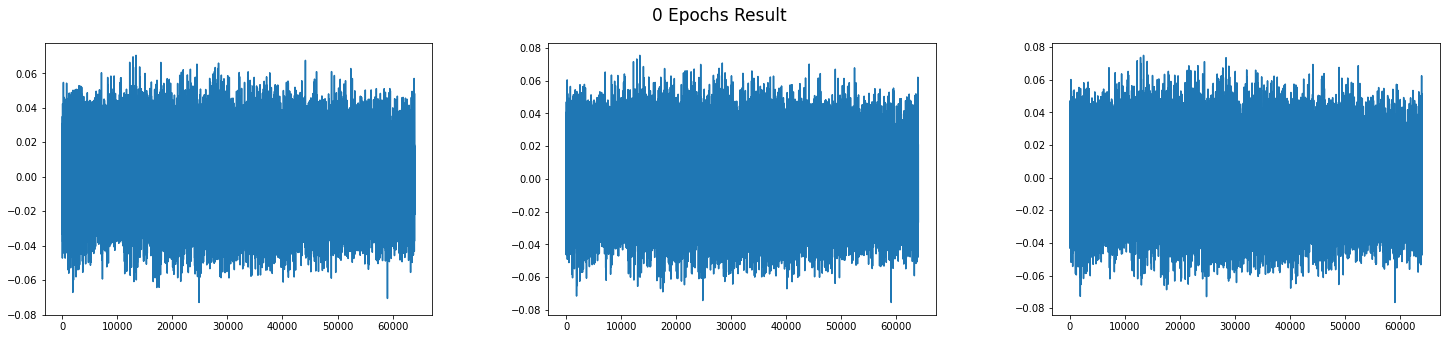

4/4 [==============================] - 1s 156ms/step


4/4 [==============================] - 1s 145ms/step
epochs:  2
4/4 [==============================] - 1s 157ms/step


4/4 [==============================] - 1s 161ms/step


4/4 [==============================] - 1s 170ms/step
epochs:  4
4/4 [==============================] - 1s 147ms/step


4/4 [==============================] - 1s 152ms/step
epochs:  6
4/4 [==============================] - 1s 156ms/step


4/4 [==============================] - 1s 303ms/step


4/4 [==============================] - 1s 238ms/step
epochs:  8
4/4 [==============================] - 1s 269ms/step


4/4 [==============================] - 1s 290ms/step


4/4 [==============================] - 1s 231ms/step
epochs:  10
Time since start: 9899.0
1/1 [==============================] - 0s 120ms/step


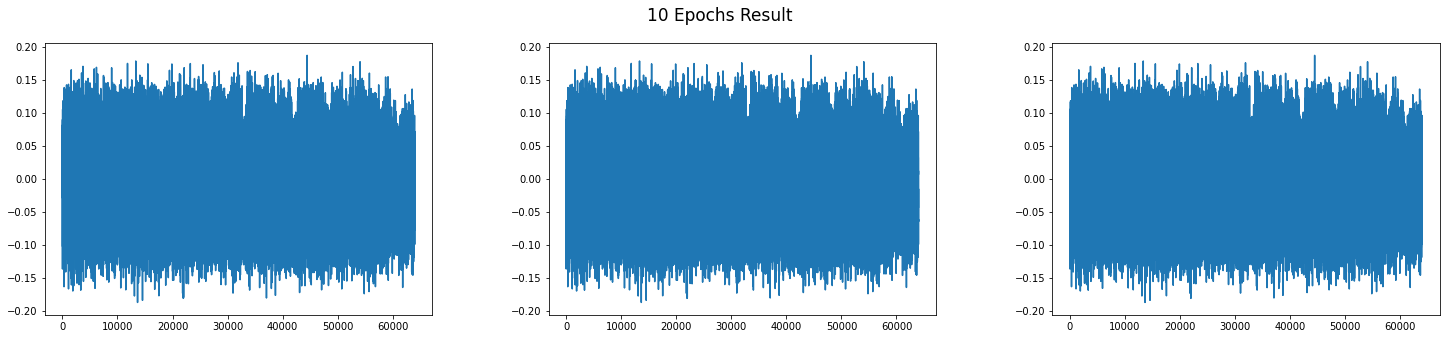

4/4 [==============================] - 1s 155ms/step


4/4 [==============================] - 1s 151ms/step
epochs:  12
4/4 [==============================] - 1s 153ms/step


4/4 [==============================] - 1s 153ms/step


4/4 [==============================] - 1s 154ms/step
epochs:  14
4/4 [==============================] - 1s 172ms/step


4/4 [==============================] - 1s 169ms/step
epochs:  16
4/4 [==============================] - 1s 170ms/step


4/4 [==============================] - 1s 148ms/step


4/4 [==============================] - 1s 155ms/step
epochs:  18
4/4 [==============================] - 1s 154ms/step


4/4 [==============================] - 1s 169ms/step


4/4 [==============================] - 1s 170ms/step
epochs:  20
Time since start: 19330.0
1/1 [==============================] - 0s 78ms/step


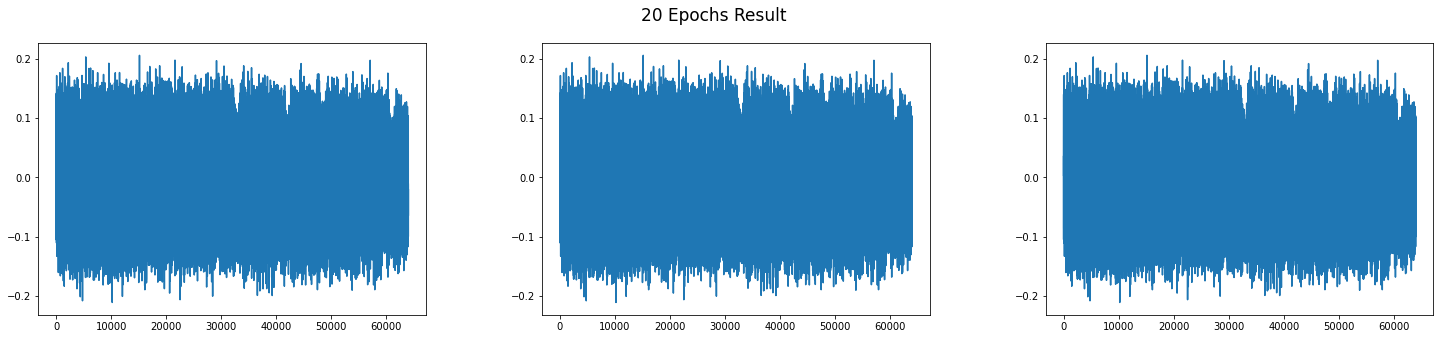

4/4 [==============================] - 1s 152ms/step


4/4 [==============================] - 1s 170ms/step
epochs:  22
4/4 [==============================] - 1s 167ms/step


4/4 [==============================] - 1s 180ms/step


4/4 [==============================] - 1s 184ms/step
epochs:  24
4/4 [==============================] - 1s 161ms/step


4/4 [==============================] - 1s 154ms/step
epochs:  26
4/4 [==============================] - 1s 200ms/step


4/4 [==============================] - 1s 146ms/step


4/4 [==============================] - 1s 146ms/step
epochs:  28
4/4 [==============================] - 1s 149ms/step


4/4 [==============================] - 1s 177ms/step


4/4 [==============================] - 1s 179ms/step
epochs:  30
Time since start: 27830.0
1/1 [==============================] - 0s 71ms/step


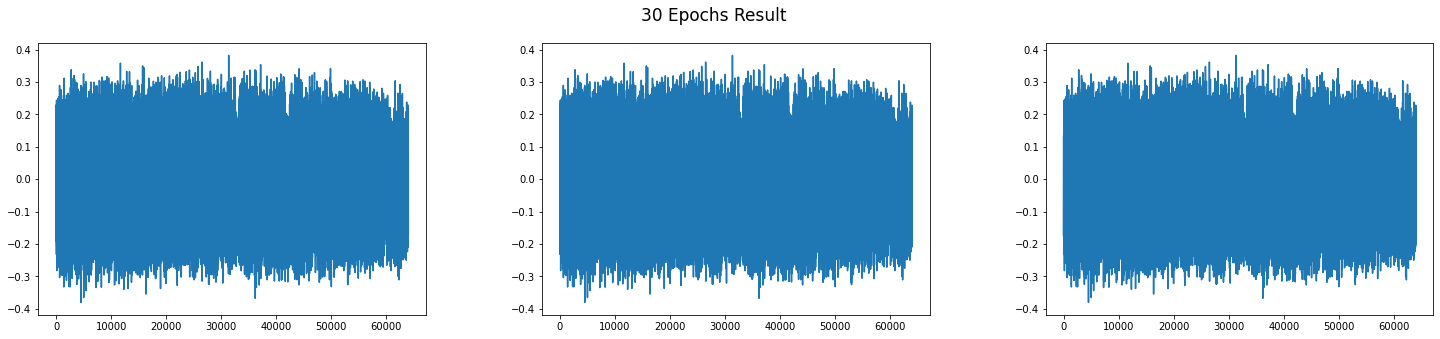

4/4 [==============================] - 1s 170ms/step


4/4 [==============================] - 1s 158ms/step
epochs:  32
4/4 [==============================] - 1s 154ms/step


4/4 [==============================] - 1s 152ms/step


4/4 [==============================] - 1s 150ms/step
epochs:  34
4/4 [==============================] - 1s 156ms/step


4/4 [==============================] - 1s 177ms/step
epochs:  36
4/4 [==============================] - 1s 168ms/step


4/4 [==============================] - 1s 174ms/step


4/4 [==============================] - 1s 174ms/step
epochs:  38
4/4 [==============================] - 1s 180ms/step


4/4 [==============================] - 1s 192ms/step
epochs:  39
Time since start: 35938.0
Training Complete.


In [14]:
import time

D_loss = []
G_loss = []
epochs = 40 
batch_size = 128
current_time = time.time()

for e in range(epochs):
    start_time = time.time()
    for _ in range(batch_size):
        # I reccomend you to look "Training Diagram" (at the top) 
        noise = np.random.normal(0,1, [batch_size,100])
        
        generated_audio = g.predict(noise)
       
        audio_batch = x_train[np.random.randint(low = 0, high = x_train.shape[0], size = batch_size)] #get samples from real data
        
        x = np.concatenate([audio_batch, generated_audio])
        
        y_dis = np.zeros(batch_size*2) 
        y_dis[:batch_size] = 1 # we labeled real audios as 1 and generated audios as 0
        
        d.trainable = True
        d_loss = d.train_on_batch(x,y_dis) # we are training discriminator (train_on_batch)
        
        noise = np.random.normal(0,1,[batch_size,100])
        
        y_gen = np.ones(batch_size) # our generator says "these audios are real"
        
        d.trainable = False
        
        g_loss = gan.train_on_batch(noise, y_gen) #train_on_batch
        
        D_loss.append(d_loss)
        G_loss.append(g_loss)
        
    if (e%2 == 0) or (e == epochs-1) :
        print("epochs: ",e)
    if e == epochs-1:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        print("Training Complete.")
    
    # printing results
    if e%10 == 0:
        print("Time since start: {}".format(np.round(start_time - current_time)))
        show_gen_samples(e)



In [15]:
g.save("audio_generator.h5")
d.save("audio_discriminator.h5")

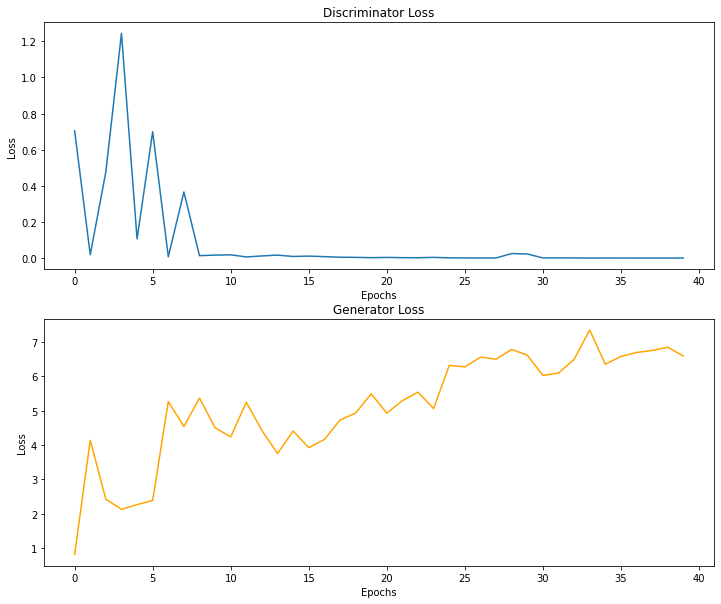

In [16]:
index = 0
D_loss2 = []
G_loss2 = []

for i in range(1,epochs+1):
    D_loss2.append(D_loss[index])
    G_loss2.append(G_loss[index])
    index += batch_size

fig, axs = plt.subplots(2, 1, figsize = (12,10))

axs[0].plot(D_loss2, label = "Discriminator Loss")
axs[1].plot(G_loss2, label = "Generator Loss", color = "orange")

axs[0].set_xlabel("Epochs")
axs[1].set_xlabel("Epochs")

axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Loss")

axs[0].set_title("Discriminator Loss")
axs[1].set_title("Generator Loss")
plt.show()

1/1 [==============================] - 0s 82ms/step


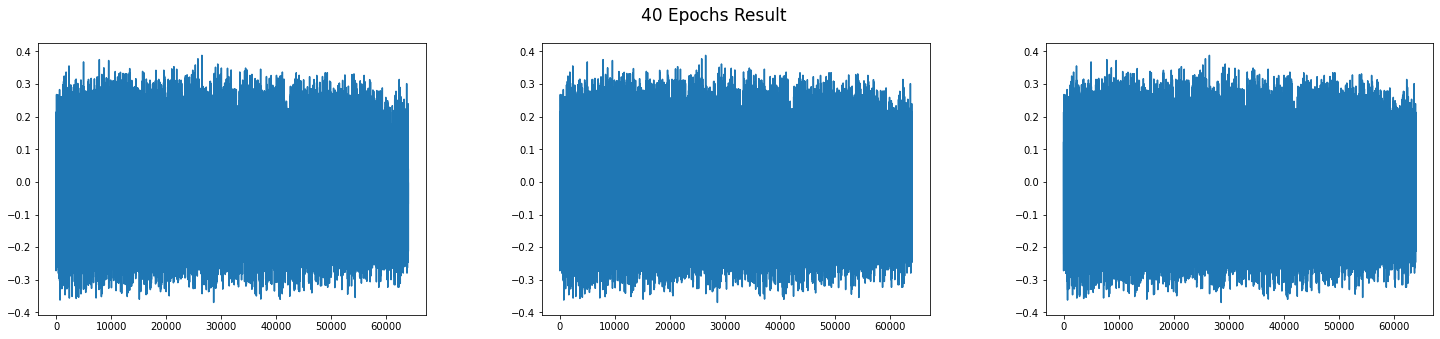

In [17]:
show_gen_samples(epochs = epochs)